# Phase 2: Feature Extraction and SVM Training

In [17]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color
from scipy import ndimage
from PIL import ImageTk, Image
import joblib
import os
import random
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import det_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay, confusion_matrix, DetCurveDisplay
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
def compute_grad(np_image, filter_ = "default" ):
    image=np.float32(np_image) 
    #Here designed 3 different kernels for ablation study.
    if filter_ == "Sobel":
        kernel_x=np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]], dtype=np.float32)
        kernel_y=np.array([[-1, -2, -1],
                           [ 0,  0,  0],
                           [ 1,  2,  1]], dtype=np.float32)
    elif filter_ == "Prewitt":
        kernel_x = np.array([[-1, 0, 1],
                             [-1, 0, 1],
                             [-1, 0, 1]], dtype=np.float32)
        kernel_y = np.array([[-1, -1, -1],
                             [ 0,  0,  0],
                             [ 1,  1,  1]], dtype=np.float32)     
    else:
        kernel_x = np.array([[-1, 0, 1]], dtype=np.float32) #use [-1,0,1] filter without smoothing as required in default settings
        kernel_y = np.array([[-1],
                             [0], 
                             [1]], dtype=np.float32) #use [-1,0,1] filter without smoothing as required 
    grad_x = cv2.filter2D(image, -1, kernel_x) #filter applied on x direction
    grad_y = cv2.filter2D(image, -1, kernel_y) #filter applied on y direction
    
    mag, ang = cv2.cartToPolar(grad_x, grad_y, angleInDegrees = True) #use CV2's cartToPolar to get magtitude and angel (in 360 degree)
    #based on the documentation found on the CV2 webpage: The angles are calculated with accuracy about 0.3 degrees. 
    #https://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html#carttopolar 
    return mag, ang

In [5]:
def compute_histogram(mag_cell, ang_cell, num_bins=9, angle_ = 180):
    bin_size = angle_ // num_bins # Oritation Bin (change for Ablation Study)
    histogram = np.zeros(num_bins) # create a container for histogram
    for i in range(mag_cell.shape[0]): #iterate each mag and ang cell then put in the correct bin for histogram
        for j in range(mag_cell.shape[1]):
            mag = mag_cell[i, j]  
            if angle_ == 180: # (change for Ablation Study)
                ang = ang_cell[i, j]
                ang = ang % 180 #convert 360 degree to 180 degree, from signed angle to un-signed angle
            else:
                ang = ang_cell[i, j]
            bin_ = int(ang // bin_size) % num_bins
            histogram[bin_] += mag  #put gradient value into oritation bin
    return histogram

In [7]:
def compute_hog(image, cell_size=8, block_size=16, num_bins=9, block_stride = 1,filter_ = "default", angle_ = 180 ): #(Change Settings for Ablation Study)
    
    height, width = image.shape
    mag, ang = compute_grad(image,filter_ )
    number_of_Xcells = width // cell_size #how many cells in X 
    number_of_Ycells = height // cell_size #how many cells in Y

    cell_histograms = np.zeros((number_of_Ycells, number_of_Xcells, num_bins)) 

    for y in range(number_of_Ycells):
        for x in range(number_of_Xcells):
            y1 = y * cell_size  #Starting Index of Y
            y2 = y1 + cell_size #Ending Index of Y
            x1 = x * cell_size  #Starting Index of X
            x2 = x1 + cell_size #Ending Index of X

            mag_cell = mag[y1:y2, x1:x2] #extract correct section of magtitude 
            ang_cell = ang[y1:y2, x1:x2] #extract correct section of angel

            cell_histograms[y, x, :] = compute_histogram(mag_cell, ang_cell, num_bins, angle_) #put result into the cell_histograms

    block_number = block_size // cell_size
    block_hist = []
    #sliding blocks on Y and X, here I've added step size, if cell size is 8, block size is 32, I can slide cell by cell 
    #or every second cell for the block nomalisation 
    for y in range(0, number_of_Ycells - block_number + 1, block_stride): 
        for x in range(0, number_of_Xcells - block_number + 1, block_stride):
            block = cell_histograms[y:y+block_number, x:x+block_number, :].flatten() #flatten into one vector
            eps = 1e-5 #to avoid divided by zero. 
            block_norm_1 = block / (np.linalg.norm(block) + eps)  #First normalisaiton
            block_norm_1 = np.clip(block_norm_1, 0, 0.2)  #Clip Lowe-style , mentioned in paper : Lowe's Scale Invariant Feature Transformation (SIFT)
            block_norm_2 = block_norm_1 / (np.linalg.norm(block_norm_1) + eps) #Second normalisation
            block_hist.append(block_norm_2) 

    return np.concatenate(block_hist)

##### Ready to test an image

In [8]:
original_image = Image.open("../Dataset/non_human_v2_train/crop_000002_R1.jpg")
np_image = np.array(original_image.convert('L'))
np_image=np.float32(np_image)

In [9]:
features_selfwritten = compute_hog(np_image, cell_size=8, block_size=16, num_bins=9, block_stride = 1,filter_ = "default", angle_ = 180)
features_selfwritten

array([0.02685909, 0.02479255, 0.15029126, ..., 0.06479355, 0.        ,
       0.        ])

Using the skimage package

In [10]:
features = hog(
    np_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    transform_sqrt=False,  # no gamma correction
    visualize=False,
    feature_vector=True
)
features

array([0.02685945, 0.02479289, 0.15029332, ..., 0.0647947 , 0.        ,
       0.        ], dtype=float32)

### Extract HOG on Training set

In [15]:
def load_and_extract_hog_features(image_paths, compute_hog):
    """
    Load images and extract HOG features for a list of image paths.
    
    Args:
        image_paths (list): List of paths to images
        compute_hog (function): Function to compute HOG features
        
    Returns:
        numpy.ndarray: Array of HOG features
    """
    features = []
    for img_path in image_paths:
        # Read image and convert to grayscale
        img = cv2.imread(str(img_path))
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hog_features = compute_hog(gray)
            features.append(hog_features)
    return np.array(features)

# Set random seed for reproducibility
random.seed(42)

# Define paths
human_train_path = Path("../Dataset/human_training")
non_human_train_path = Path("../Dataset/non_human_v2_train")

# Get all image files
human_images = list(human_train_path.glob("*"))
non_human_images = list(non_human_train_path.glob("*"))

# Randomly select 250 images from each class
selected_human = random.sample(human_images, min(250, len(human_images)))
selected_non_human = random.sample(non_human_images, min(250, len(non_human_images)))

# Extract HOG features
print("Extracting HOG features from human images...")
human_features = load_and_extract_hog_features(selected_human, compute_hog)

print("Extracting HOG features from non-human images...")
non_human_features = load_and_extract_hog_features(selected_non_human, compute_hog)

# Create labels (1 for human, 0 for non-human)
human_labels = np.ones(len(human_features))
non_human_labels = np.zeros(len(non_human_features))

# Combine features and labels
X_train = np.vstack([human_features, non_human_features])
y_train = np.concatenate([human_labels, non_human_labels])

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Number of human samples: {len(human_features)}")
print(f"Number of non-human samples: {len(non_human_features)}")


# Save the processed data
np.save("../Dataset/X_train.npy", X_train)
np.save("../Dataset/y_train.npy", y_train)

Extracting HOG features from human images...
Extracting HOG features from non-human images...
Training data shape: (499, 3780)
Training labels shape: (499,)
Number of human samples: 249
Number of non-human samples: 250


### Train SVM (using extracted HOG)

In [18]:
# Load the training data
X_train = np.load("../Dataset/X_train.npy")
y_train = np.load("../Dataset/y_train.npy")

# Initialize and train the SVM classifier
print("Training SVM classifier...")
svm_classifier = LinearSVC(
    C=1.0,  # Regularization parameter
    max_iter=10000,  # Maximum number of iterations
    random_state=42
)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Print training accuracy
train_accuracy = svm_classifier.score(X_train, y_train)
print(f"\nTraining accuracy: {train_accuracy:.4f}")

# Save the trained model
model_path = "../Dataset/svm_hog_classifier.joblib"
joblib.dump(svm_classifier, model_path)
print(f"\nModel saved to: {model_path}")

# Print model parameters
print("\nModel parameters:")
print(f"C (regularization parameter): {svm_classifier.C}")
print(f"Number of features: {svm_classifier.n_features_in_}")
print(f"Number of classes: {len(svm_classifier.classes_)}")

Training SVM classifier...

Training accuracy: 1.0000

Model saved to: ../Dataset/svm_hog_classifier.joblib

Model parameters:
C (regularization parameter): 1.0
Number of features: 3780
Number of classes: 2


### Performance

Loading and processing test images...
Extracting HOG features from test images...

Test set size: 200 images
Human test samples: 100
Non-human test samples: 100

Classification Error: 0.0300


<Figure size 800x600 with 0 Axes>

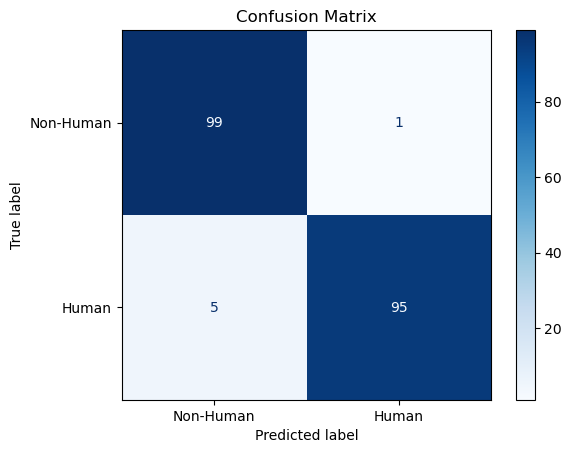

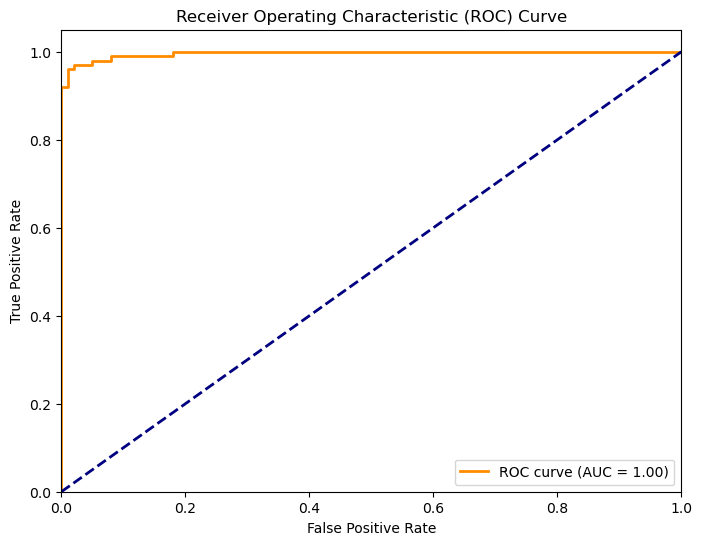


Classification Report:


NameError: name 'classification_report' is not defined

In [21]:

# Set random seed for reproducibility
random.seed(42)

# Load the trained model
svm_classifier = joblib.load("../Dataset/svm_hog_classifier.joblib")

# Load test images and extract features
print("Loading and processing test images...")
human_test_path = Path("../Dataset/human_testing")
non_human_test_path = Path("../Dataset/non_human_v2_test")

# Get all test images and randomly select 100 from each class
human_test_images = list(human_test_path.glob("*"))
non_human_test_images = list(non_human_test_path.glob("*"))

selected_human_test = random.sample(human_test_images, min(100, len(human_test_images)))
selected_non_human_test = random.sample(non_human_test_images, min(100, len(non_human_test_images)))

# Extract HOG features for test set
print("Extracting HOG features from test images...")
human_test_features = load_and_extract_hog_features(selected_human_test, compute_hog)
non_human_test_features = load_and_extract_hog_features(selected_non_human_test, compute_hog)

# Combine test features and create labels
X_test = np.vstack([human_test_features, non_human_test_features])
y_test = np.concatenate([np.ones(len(human_test_features)), np.zeros(len(non_human_test_features))])

print(f"\nTest set size: {len(X_test)} images")
print(f"Human test samples: {len(human_test_features)}")
print(f"Non-human test samples: {len(non_human_test_features)}")

# Make predictions
y_pred = svm_classifier.predict(X_test)
y_score = svm_classifier.decision_function(X_test)

# Calculate classification error
classification_error = 1 - svm_classifier.score(X_test, y_test)
print(f"\nClassification Error: {classification_error:.4f}")

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Human', 'Human'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Generate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Human', 'Human']))